In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import DenseNet121, ResNet50 ,VGG16
from tensorflow.keras.models import Model
import warnings
warnings.filterwarnings('ignore')

2024-09-30 12:52:21.791204: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# 定义数据集路径（真实和虚假图像）
train_data_dir = '../input/real-vs-fake/train'
validation_data_dir = '../input/real-vs-fake/valid'
test_data_dir = '../input/real-vs-fake/test'

In [3]:
print("Train_dir Subfolders: ", os.listdir(train_data_dir))
print("Valid_dir Subfolders: ", os.listdir(validation_data_dir))
print("Test_dir Subfolders: ", os.listdir(test_data_dir))

Train_dir Subfolders:  ['real', 'fake']
Valid_dir Subfolders:  ['real', 'fake']
Test_dir Subfolders:  ['real', 'fake']


In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)
target_size = (128,128)
batch_size = 32  # Update this according to your batch size

# Load data from directories
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)


test_generator = val_test_datagen.flow_from_directory(
    test_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure test data is not shuffled
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [5]:
# Load VGG16 model with pre-trained weights, excluding the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

2024-09-30 12:52:45.794949: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2024-09-30 12:52:45.826709: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-30 12:52:45.826833: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.90GiB deviceMemoryBandwidth: 510.07GiB/s
2024-09-30 12:52:45.826859: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2024-09-30 12:52:45.829089: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2024-09-30 12:52:45.830860: I tensorflow/stream_executor/platform/d

In [6]:
# Add custom layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
#x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers[-3:]:  # Unfreeze the last 4 layers (customize this as needed)
    layer.trainable = True

# Recompile the model after making layers trainable
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # You can reduce the learning rate further if needed
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [8]:
# Define callbacks
callbacks = [
    #ModelCheckpoint('vgg16_best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
]

In [46]:
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)      

In [9]:
history = model.fit(
    train_generator,
    batch_size=32, 
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10


2024-09-30 12:53:14.225501: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2024-09-30 12:53:14.357262: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7


3125/3125 [==============================] - 289s 92ms/step - loss: 0.2767 - accuracy: 0.8791 - val_loss: 0.1894 - val_accuracy: 0.9233
Epoch 2/10
3125/3125 [==============================] - 275s 88ms/step - loss: 0.1056 - accuracy: 0.9591 - val_loss: 0.1233 - val_accuracy: 0.9531
Epoch 3/10
3125/3125 [==============================] - 272s 87ms/step - loss: 0.0611 - accuracy: 0.9771 - val_loss: 0.0862 - val_accuracy: 0.9686
Epoch 4/10
3125/3125 [==============================] - 269s 86ms/step - loss: 0.0393 - accuracy: 0.9854 - val_loss: 0.2168 - val_accuracy: 0.9251
Epoch 5/10
3125/3125 [==============================] - 267s 85ms/step - loss: 0.0260 - accuracy: 0.9906 - val_loss: 0.0505 - val_accuracy: 0.9819
Epoch 6/10
3125/3125 [==============================] - 267s 85ms/step - loss: 0.0196 - accuracy: 0.9929 - val_loss: 0.0538 - val_accuracy: 0.9808
Epoch 7/10
3125/3125 [==============================] - 267s 85ms/step - loss: 0.0161 - accuracy: 0.9943 - val_loss: 0.0555 - val

In [47]:
test_metrics = model.evaluate(test_generator)
print("Test metrics:", test_metrics[1])


625/625 [==============================] - 29s 46ms/step - loss: 0.0586 - accuracy: 0.9836
Test metrics: 0.9835500121116638


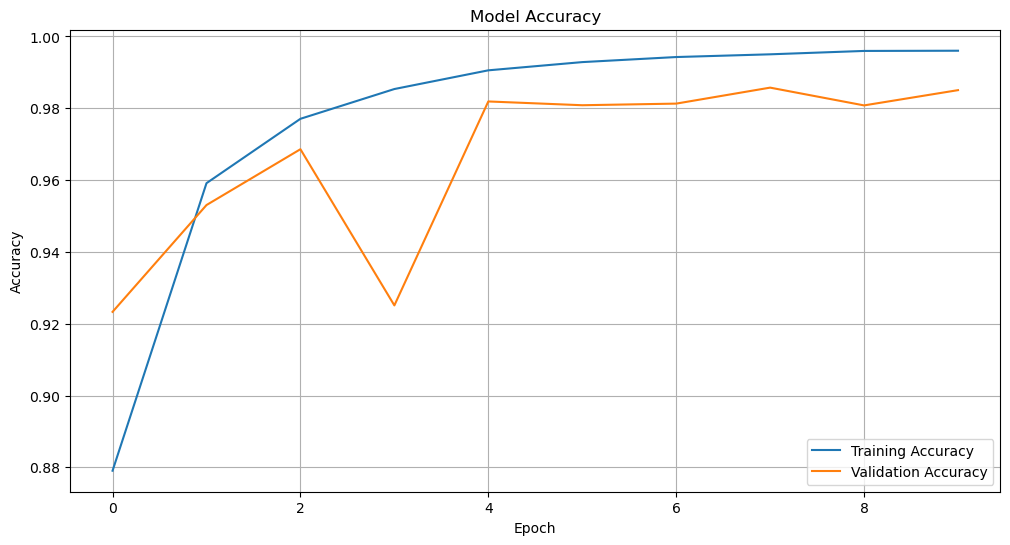

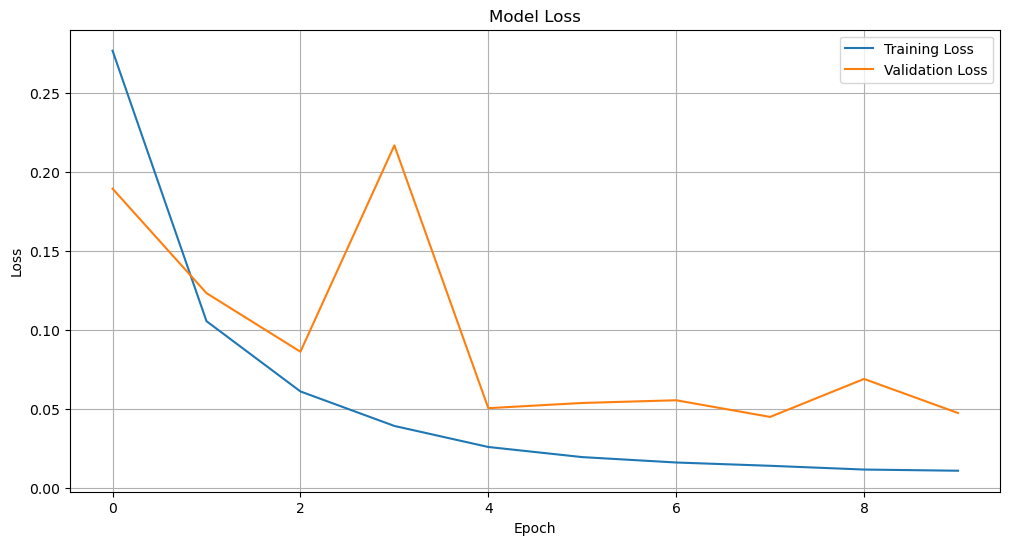

In [10]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [11]:
# Generate predictions on the test set
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)

# The model output is the probability of the image being real
# Convert probabilities to percentage
predicted_percentages = predictions * 100

# Convert to predicted classes with a threshold of 50%
predicted_classes = np.where(predicted_percentages > 50, 1, 0)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

625/625 [==============================] - 33s 53ms/step
              precision    recall  f1-score   support

        fake       0.98      0.99      0.98     10000
        real       0.99      0.98      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000



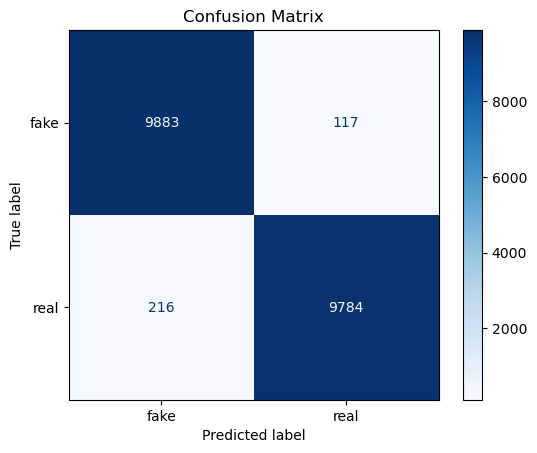

In [12]:
# 3. Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# 4. Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [13]:
import os

# Check the current working directory
print(os.getcwd())

# Save the model
model.save('../output/Vgg16_model.h5')

# List files in the current directory to confirm the save
print(os.listdir("../output"))

/home/wuhen/aidetection/src
['best_model.h5', 'Vgg16_model.h5', 'model2.h5', 'model3.h5', '.ipynb_checkpoints', 'model1.h5', 'pic']
